In [ ]:
import os

import warnings

from IPython.display import HTML

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
import seaborn as sns
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, default_collate, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

from PIL import Image, ImageFile

from tqdm.auto import tqdm

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
input_directory = '/content/drive/MyDrive/Bone_Fracture_Binary_Classification'
output_directory = '/content/drive/MyDrive/working'
dataset_directory = f'{output_directory}'
output_train_directory = '/content/drive/MyDrive/working/train'
output_dev_directory = '/content/drive/MyDrive/working/val'
output_test_directory = '/content/drive/MyDrive/working/test'

In [ ]:
# Iterate through subdirectories
def removeCorruptFiles(directory_path):
  for item in os.listdir(directory_path):
    item_path = os.path.join(directory_path, item)

    if os.path.isdir(item_path):
      removeCorruptFiles(item_path)
    else:
      try:
        Image.open(item_path).verify()
      except (IOError, SyntaxError):
        os.remove(item_path)
        print(f'Removed corrupted image: {item}')

  # print("Corrupted image removal complete.")

In [ ]:
def removeEmptySubdirectories(directory):
    # Iterate over each entry in the directory
    for entry in os.listdir(directory):
        # Create full path
        full_path = os.path.join(directory, entry)

        # If entry is a directory, recursively remove empty subdirectories
        if os.path.isdir(full_path):
            removeEmptySubdirectories(full_path)

            # Check if directory is empty after removal
            if not os.listdir(full_path):
                # Remove the directory if it's empty
                os.rmdir(full_path)
                print(f"Removed empty directory: {full_path}")

In [ ]:
def copyDatasetIntoWorkingDir(source_directory, destination_directory):
    # Remove the destination directory if it already exists
    if os.path.exists(destination_directory):
        shutil.rmtree(destination_directory)


    shutil.copytree(source_directory, destination_directory)

In [ ]:
def count_images(directory):
    total_images = sum([len(files) for r, d, files in os.walk(directory)])
    print(f"Total images in {directory}: {total_images}")
    return total_images

# Count images in train, validation, and test sets
train_images = count_images(output_train_directory)
val_images = count_images(output_dev_directory)
test_images = count_images(output_test_directory)

Total images in /content/drive/MyDrive/working/train: 9246
Total images in /content/drive/MyDrive/working/val: 829
Total images in /content/drive/MyDrive/working/test: 506


Image Size Statistics:
              Width        Height
count  10581.000000  10581.000000
mean     299.818259    325.191759
std      327.716722    419.038128
min      100.000000    100.000000
25%      224.000000    224.000000
50%      224.000000    224.000000
75%      224.000000    224.000000
max     4232.000000   5823.000000


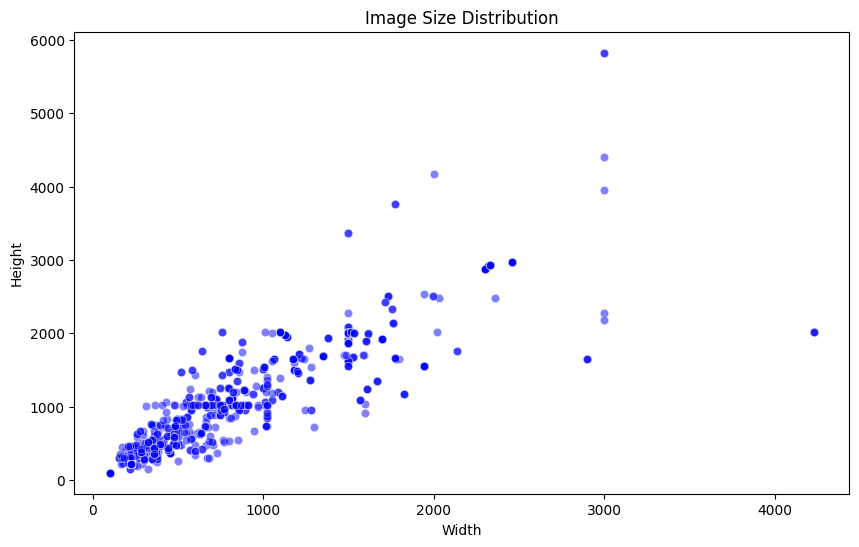

In [ ]:
def calculate_image_sizes(dataset_directory):
    sizes = []
    for subdir, dirs, files in os.walk(dataset_directory):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff', 'gif')):
                file_path = os.path.join(subdir, file)
                with Image.open(file_path) as img:
                    sizes.append(img.size)  # (width, height)
    return sizes

# Calculate image sizes
image_sizes = calculate_image_sizes(dataset_directory)

# Convert sizes to a DataFrame for easier analysis
sizes_df = pd.DataFrame(image_sizes, columns=["Width", "Height"])

# Display statistics
print("Image Size Statistics:")
print(sizes_df.describe())

# Plot distribution of image sizes
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sizes_df, x="Width", y="Height", alpha=0.5, color="blue")
plt.title("Image Size Distribution")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()


In [ ]:
IMAGE_SIZE = 224
imgSize = IMAGE_SIZE

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((imgSize, imgSize)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
#     transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
#     transforms.RandomRotation(degrees=(30, 70)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

dev_transform = transforms.Compose([
    transforms.Resize((imgSize, imgSize)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((imgSize, imgSize)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load a sample image (replace 'sample_image.jpg' with the path to your image)
img_path = '/content/drive/MyDrive/Bone_Fracture_Binary_Classification/val/fractured/000151.png'
original_img = Image.open(img_path)

# Convert the image to RGB if it's not already
original_img = original_img.convert('RGB')

# Define image size and transformations
imgSize = 224
train_transform = transforms.Compose([
    transforms.Resize((imgSize, imgSize)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Apply transformations
transformed_img = train_transform(original_img)

# Reverse normalization to visualize transformed image correctly
inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2])
])
transformed_img_vis = inverse_transform(transformed_img).clamp(0, 1)

# Convert tensor back to PIL image for visualization
transformed_img_pil = transforms.ToPILImage()(transformed_img_vis)

# Display both images side by side
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis("off")

# Transformed image
plt.subplot(1, 2, 2)
plt.imshow(transformed_img_pil)
plt.title("Transformed Image")
plt.axis("off")

plt.show()


In [ ]:
train_dataset = torchvision.datasets.ImageFolder(root = output_train_directory, transform = train_transform)
dev_dataset = torchvision.datasets.ImageFolder(root = output_dev_directory, transform = dev_transform)
test_dataset = torchvision.datasets.ImageFolder(root = output_test_directory, transform = test_transform)

In [ ]:
def my_collate(batch):
    "Puts each data field into a tensor with outer dimension batch size"
    batch = list(filter(lambda x:x is not None, batch))
    return default_collate(batch)

In [ ]:
batchsize = 16

train_dataloader = DataLoader(train_dataset, batch_size = batchsize, shuffle = True, collate_fn = my_collate)
dev_dataloader = DataLoader(dev_dataset, batch_size = batchsize, collate_fn = my_collate)
test_dataloader = DataLoader(test_dataset, batch_size = batchsize, collate_fn = my_collate)

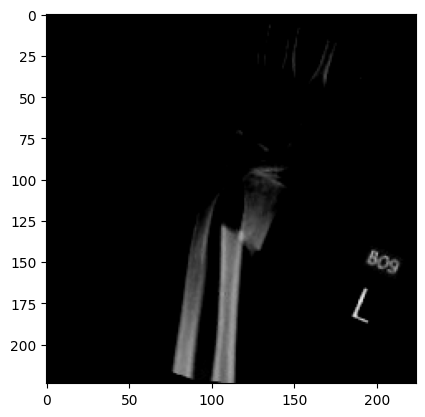

In [ ]:
X, y = next(iter(train_dataloader))
plt.imshow(X[10].permute(1,2,0))

In [ ]:
import torch
import torch.nn as nn
from transformers import ViTModel

class CustomViT(nn.Module):
    def __init__(self):
        super(CustomViT, self).__init__()
        # Load pre-trained ViT model
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

        # Attention block
        self.attention_block = nn.Sequential(
            nn.Conv2d(768, 256, kernel_size=1),  # Downscale the feature map
            nn.BatchNorm2d(256),  # Add BatchNorm for stability
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.AdaptiveAvgPool2d((1, 1))  # Pool to a fixed-size tensor
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(768 * 2 + 256, 512),  # Concatenated features + attention block output
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # Binary classification
        )

    def forward(self, x):
        # Pass through the ViT model
        vit_output = self.vit(x).last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)

        # Separate class token and patch tokens
        class_token = vit_output[:, 0, :]  # Shape: (batch_size, hidden_size)
        patch_tokens = vit_output[:, 1:, :]  # Shape: (batch_size, seq_len-1, hidden_size)

        # Reshape patch tokens for attention block
        batch_size, seq_len, hidden_size = patch_tokens.shape
        patch_tokens_reshaped = patch_tokens.transpose(1, 2).reshape(batch_size, hidden_size, 14, 14)

        # Pass through the attention block
        attention_features = self.attention_block(patch_tokens_reshaped).view(batch_size, -1)

        # Pooling: global average pooling and max pooling
        avg_pooled = vit_output.mean(dim=1)  # Shape: (batch_size, hidden_size)
        max_pooled = vit_output.max(dim=1).values  # Shape: (batch_size, hidden_size)

        # Concatenate features
        combined_features = torch.cat((avg_pooled, max_pooled, attention_features), dim=1)

        # Classify
        output = self.classifier(combined_features)

        return output

# Function to create the model, loss function, and optimizer
def makeCustomNet():
    net = CustomViT()
    lossfun = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)  # Adam optimizer
    return net, lossfun, optimizer

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net, lossfun, optimizer = makeCustomNet()
net.to(device)

# Dummy input data for testing
X = torch.randn(8, 3, 224, 224).to(device)  # Example input batch
y = torch.randint(0, 2, (8,)).to(device, dtype=torch.float)  # Example binary labels

# Forward pass
yHat = net(X).squeeze()  # Remove extra dimensions
loss = lossfun(yHat, y)  # Compute loss

print(f"Loss: {loss.item():.4f}")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Loss: 0.6953


In [ ]:
import torch
import numpy as np
from tqdm import tqdm

def function2TrainModel():
    epochs = 10  # Adjust epochs as needed

    net, lossfun, optimizer = makeCustomNet()  # Call the updated model setup function
    net.to(device)

    trainAcc = []
    devAcc = []
    trainLoss = []
    devLoss = []

    best_acc = 0  # Initialize best accuracy
    best_model = None  # To store the best model

    for epochi in tqdm(range(epochs)):

        # Training phase
        net.train()
        batchAcc = []
        batchLoss = []

        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device, dtype=torch.float)
            yHat = net(X)  # Get predictions from the model
            yHat = yHat.squeeze()  # Remove extra dimensions for loss calculation

            # Compute accuracy (Binary classification, use a threshold of 0.5)
            batchAcc.append(torch.mean(((yHat > 0.5) == y).float()) * 100)
            batchLoss.append(lossfun(yHat, y).item())  # Compute loss

            optimizer.zero_grad()
            lossfun(yHat, y).backward()  # Compute gradients
            optimizer.step()  # Update model parameters

        # Mean accuracy and loss for training
        trainAcc.append(np.mean([acc.cpu().item() for acc in batchAcc]))  # Ensure the accuracy is on CPU for numpy
        trainLoss.append(np.mean(batchLoss))  # No need for .cpu() since it's already a float

        # Evaluation phase (no gradients computed)
        net.eval()
        with torch.no_grad():
            batchLoss = []
            batchAcc = []

            for X, y in dev_dataloader:
                X, y = X.to(device), y.to(device, dtype=torch.float)
                yHat = net(X)  # Get predictions from the model
                yHat = yHat.squeeze()  # Remove extra dimensions for loss calculation

                # Compute accuracy (Binary classification)
                batchAcc.append(torch.mean(((yHat > 0.5) == y).float()) * 100)
                batchLoss.append(lossfun(yHat, y).item())  # Compute loss

            devAcc.append(np.mean([acc.cpu().item() for acc in batchAcc]))  # Ensure accuracy is on CPU for numpy
            devLoss.append(np.mean(batchLoss))  # No need for .cpu() since it's already a float

            # Check if current epoch's accuracy is the best
            if devAcc[-1] > best_acc:
                best_acc = devAcc[-1]
                best_model = net.state_dict()  # Save the best model state

        # Print the training and development accuracies for this epoch
        print(f"Epoch {epochi+1}/{epochs}")
        print(f"Training Accuracy: {trainAcc[-1]:.2f}%")
        print(f"Development Accuracy: {devAcc[-1]:.2f}%")
        print(f"Training Loss: {trainLoss[-1]:.4f}")
        print(f"Development Loss: {devLoss[-1]:.4f}")
        print("-" * 40)

    # Optionally, load the best model state back into the model
    net.load_state_dict(best_model)

    return trainAcc, devAcc, trainLoss, devLoss, net


In [ ]:
import random

# Setting seeds
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()  # Ensure reproducibility

In [ ]:
import torch

# Assuming `net` is your trained model
trainAcc, devAcc, trainLoss, devLoss, net = function2TrainModel()

# Save the model's state_dict
path = '/content/drive/MyDrive/model3.pth'
torch.save(net.state_dict(), path)


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 10%|█         | 1/10 [06:40<1:00:06, 400.68s/it]

Epoch 1/10
Training Accuracy: 94.80%
Development Accuracy: 81.39%
Training Loss: 0.1181
Development Loss: 0.3993
----------------------------------------


 20%|██        | 2/10 [12:12<48:00, 360.09s/it]  

Epoch 2/10
Training Accuracy: 98.81%
Development Accuracy: 97.70%
Training Loss: 0.0357
Development Loss: 0.0508
----------------------------------------


 30%|███       | 3/10 [17:44<40:30, 347.26s/it]

Epoch 3/10
Training Accuracy: 99.19%
Development Accuracy: 98.89%
Training Loss: 0.0246
Development Loss: 0.0370
----------------------------------------


 40%|████      | 4/10 [23:15<34:04, 340.71s/it]

Epoch 4/10
Training Accuracy: 99.26%
Development Accuracy: 95.50%
Training Loss: 0.0213
Development Loss: 0.1118
----------------------------------------


 50%|█████     | 5/10 [28:45<28:05, 337.12s/it]

Epoch 5/10
Training Accuracy: 99.28%
Development Accuracy: 99.34%
Training Loss: 0.0214
Development Loss: 0.0165
----------------------------------------


 60%|██████    | 6/10 [34:17<22:21, 335.32s/it]

Epoch 6/10
Training Accuracy: 99.60%
Development Accuracy: 96.15%
Training Loss: 0.0131
Development Loss: 0.0719
----------------------------------------


 70%|███████   | 7/10 [39:48<16:41, 333.78s/it]

Epoch 7/10
Training Accuracy: 99.42%
Development Accuracy: 96.26%
Training Loss: 0.0145
Development Loss: 0.0723
----------------------------------------


 80%|████████  | 8/10 [45:19<11:05, 332.84s/it]

Epoch 8/10
Training Accuracy: 99.32%
Development Accuracy: 99.22%
Training Loss: 0.0188
Development Loss: 0.0199
----------------------------------------


 90%|█████████ | 9/10 [50:50<05:32, 332.50s/it]

Epoch 9/10
Training Accuracy: 99.75%
Development Accuracy: 99.13%
Training Loss: 0.0081
Development Loss: 0.0331
----------------------------------------


100%|██████████| 10/10 [56:21<00:00, 338.15s/it]

Epoch 10/10
Training Accuracy: 99.69%
Development Accuracy: 98.74%
Training Loss: 0.0099
Development Loss: 0.0333
----------------------------------------


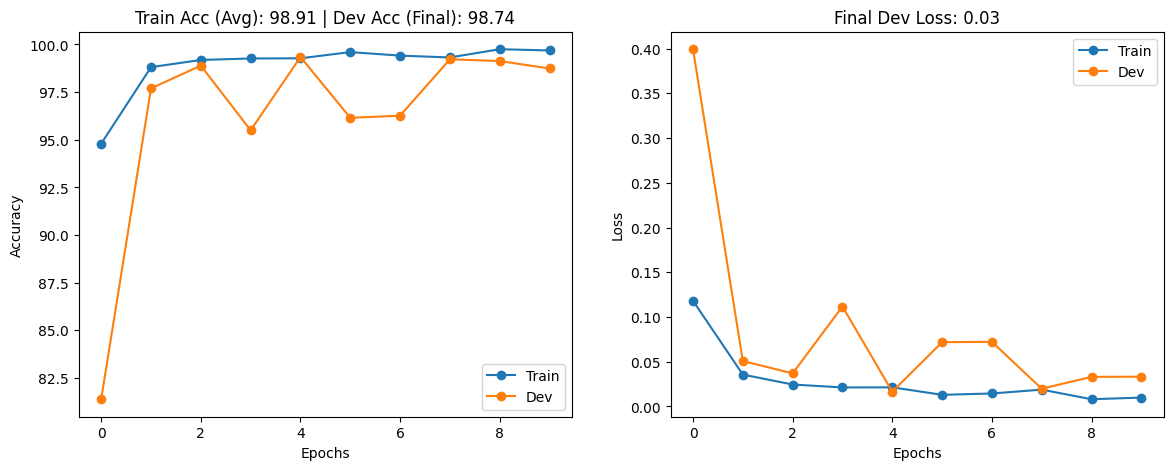

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming trainAcc, devAcc, trainLoss, and devLoss are already defined as lists containing the accuracy and loss values

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot for accuracy
ax[0].plot(trainAcc, 'o-', label='Train')
ax[0].plot(devAcc, 'o-', label='Dev')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

# Calculate average training accuracy over all epochs
train_acc_avg = np.mean(trainAcc)  # Average training accuracy
dev_acc_final = devAcc[-1]  # Final development accuracy (last epoch)

# Set title with both training and development accuracy
ax[0].set_title(f'Train Acc (Avg): {train_acc_avg:.2f} | Dev Acc (Final): {dev_acc_final:.2f}')

# Plot for loss
ax[1].plot(trainLoss, 'o-', label='Train')
ax[1].plot(devLoss, 'o-', label='Dev')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

# Get the final dev loss (last epoch)
dev_loss_final = devLoss[-1]  # Final development loss (last epoch)

# Set the title with the final development loss
ax[1].set_title(f'Final Dev Loss: {dev_loss_final:.2f}')

plt.show()


In [ ]:
net.eval()

images = []
yTrue, yPred = [], []

with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device, dtype=torch.float)
        yHat = net(X)
        yHat = yHat.squeeze()
        yHat, y = yHat.cpu(), y.cpu()

        images.extend(X)
        yTrue.extend(y)
        yPred.extend((yHat > .0).float())

In [ ]:
yTrue, yPred = [yItem.item() for yItem in yTrue], [yItem.item() for yItem in yPred]

In [ ]:
def showComparision(images, yTrue, yPred):
    cols = 3
    rows = int(len(images) / cols)

    fig, ax = plt.subplots(rows, cols, figsize = (50, 200))
    fig.subplots_adjust(hspace=.5, wspace=.2)  # Adjust spacing between subplots

    for idx, image in enumerate(images):
        yActual = int(yTrue[idx])
        yPredicted = int(yPred[idx])

        yActualStr = test_dataset.classes[yActual]
        yPredictedStr = test_dataset.classes[yPredicted]

        correctPrediction = (yActual == yPredicted)
        color = 'green' if correctPrediction else 'red'

        i = int(idx / cols)
        j = int(idx % cols)

        # Normalize pixel values to range [0, 1]
        image = image.cpu().view(-1, imgSize, imgSize).permute(1, 2, 0)
        image = image.numpy()  # Convert tensor to NumPy array
        image = (image - np.min(image)) / (np.max(image) - np.min(image))  # Normalize

        # Add padding to the image
        pad = 0.1
        ax[i][j].imshow(image, aspect='auto')
        ax[i][j].set_title(f'Actual: {yActualStr} | Predicted: {yPredictedStr}', fontsize = 40, color = color, y = 1.05)
        ax[i][j].axis('off')

        border = Rectangle((0, 0), image.shape[1]-1, image.shape[0]-1, linewidth=5, edgecolor=color, facecolor='none')
        ax[i][j].add_patch(border)

In [ ]:
visualizableCount = 33
visualizableImages = images[:visualizableCount]
visualizableYTrue = yTrue[:visualizableCount]
visualizableYPred = yPred[:visualizableCount]
showComparision(visualizableImages, visualizableYTrue, visualizableYPred)

Output hidden; open in https://colab.research.google.com to view.

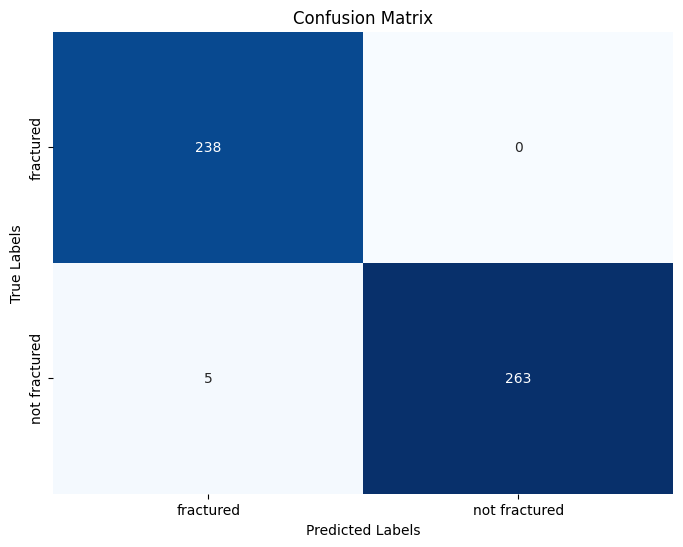

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming yTrue and yPred are already defined
# yTrue: True labels
# yPred: Predicted labels

cm = confusion_matrix(yTrue, yPred)

# Assuming test_dataset.classes is correctly defined
class_names = test_dataset.classes

# Define the colormap
cmap = 'Blues'  # You can use 'viridis', 'coolwarm', etc.

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
precision = precision_score(yTrue, yPred)
recall = recall_score(yTrue, yPred)
f1Score = f1_score(yTrue, yPred)

In [ ]:
from sklearn.metrics import classification_report
class_names = class_names  # Example class names

print(classification_report(yTrue, yPred, target_names=class_names))

               precision    recall  f1-score   support

    fractured       0.98      1.00      0.99       238
not fractured       1.00      0.98      0.99       268

     accuracy                           0.99       506
    macro avg       0.99      0.99      0.99       506
 weighted avg       0.99      0.99      0.99       506



Test Accuracy: 0.99


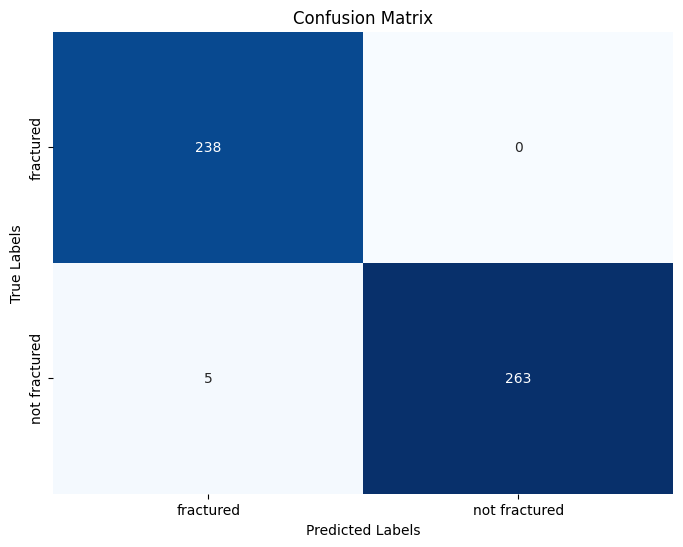

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming yTrue and yPred are already defined
# yTrue: True labels
# yPred: Predicted labels

# Compute confusion matrix
cm = confusion_matrix(yTrue, yPred)

# Compute accuracy
accuracy = accuracy_score(yTrue, yPred)

# Print test accuracy
print(f"Test Accuracy: {accuracy:.2f}")

# Assuming test_dataset.classes is correctly defined
class_names = test_dataset.classes

# Define the colormap
cmap = 'Blues'  # You can use 'viridis', 'coolwarm', etc.

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
